# Lab 1

## Part 2: Neural Machine Translation in the wild
In the second part of the homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.
* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* or just fine-tunning BERT)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
! pip  install subword-nmt
! pip install nltk
! pip install torchtext
! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

--2020-04-05 06:39:57--  https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  39.0MB/s    in 0.3s    

2020-04-05 06:39:57 (39.0 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9290
Unique tokens in target (en) vocabulary: 6745


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'телевидения',
 'американской',
 'красная',
 'cosy',
 'челси',
 'marianna',
 'фонда',
 'дизайне',
 'стимбоут']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::1000]

['<unk>', 'sport', 'delta', 'córdoba', 'mountainous', 'sited', 'malagueta']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['the', 'property', 'features', 'an', 'outdoor', 'pool', 'and', 'a', 'sheltered', 'terrace', '.'], 'src': ['на', 'территории', 'обустроены', 'открытый', 'бассейн', 'и', 'крытая', 'терраса', '.']}


Let's check the length distributions:

Length distribution in Train data


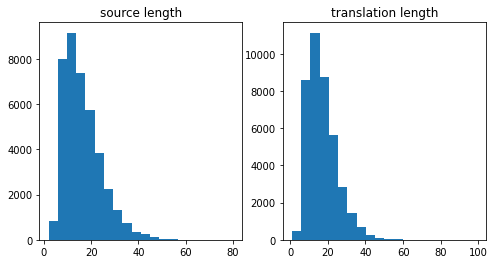

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


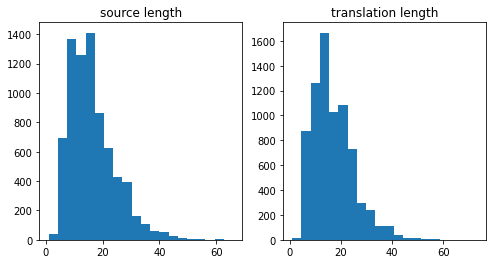

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.LongTensor of size 50x128]
	[.src]:[torch.LongTensor of size 50x128]
torch.Size([50, 128]) torch.Size([50, 128])


In [ ]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9290, 256, padding_idx=0)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
    (lm_head): Linear(in_features=512, out_features=9290, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(6745, 256, padding_idx=0)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6745, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 19,687,331 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, lm=False):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        if lm:
            output = model(src, lm=lm)
        else:
            output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, lm=False):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            if lm:
                output = model(src, lm=lm)
            else:
                output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

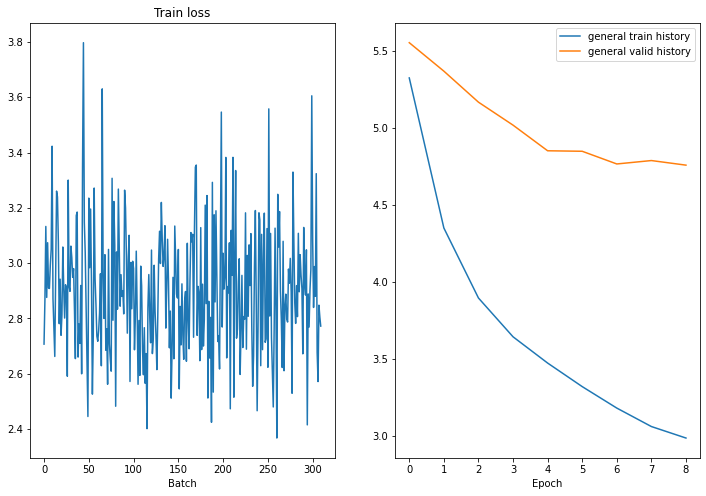

Epoch: 10 | Time: 1m 23s
	Train Loss: 2.903 | Train PPL:  18.222
	 Val. Loss: 4.710 |  Val. PPL: 111.096


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

NameError: ignored

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

NameError: ignored

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 15.50it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.55999291524233

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

In [ ]:
!pip install youtokentome

     |████████████████████████████████| 1.7MB 4.7MB/s 


In [ ]:
import youtokentome as yttm

with open('src.txt', "w") as from_out, open("trg.txt", "w") as to_out, open("data.txt") as data:
    for line in data.readlines():
        fr, to = line.strip().split('\t')[:2]
        print(fr, file=from_out)
        print(to, file=to_out)

path_src = "src.txt"
path_trg = "trg.txt"
src_bpe_model = "src.bpe"
trg_bpe_model = "trg.bpe"
VOCAB_SIZE = 5000
PAD_IDX = 0

yttm.BPE.train(data=path_src, model=src_bpe_model, vocab_size=VOCAB_SIZE, pad_id = PAD_IDX)
yttm.BPE.train(data=path_trg, model=trg_bpe_model, vocab_size=VOCAB_SIZE, pad_id=PAD_IDX)
bpe_src = yttm.BPE(model=src_bpe_model)
bpe_trg = yttm.BPE(model=trg_bpe_model)


In [ ]:
bpe_src.vocab()[::1000]

['<PAD>', 'ary', '▁Ge', '▁gardens,', '▁Paul']

In [ ]:
with open("data.txt") as data:
    pairs = list(data.readlines())[:5]
    
list(zip(*(x.strip().split('\t')[:2] for x in pairs)))

[('Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.',
  'At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.',
  'Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.',
  'Each has a TV and a private bathroom with shower.',
  'Your room comes with air conditioning and satellite TV.'),
 ('Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.',
  'В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.',
  'Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.',
  'В вашем распоряжении также телевизор и собственная ванная комната с душем.',
  'Номер оснащен кондиционером и спутниковым телевидением.')]

In [ ]:
import torch
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence


class CustomDataset(data.Dataset):
    def __init__(self, path):
        super().__init__()
        with open(path, "r") as fp:
            self.data = list(fp.readlines())
    
    def __getitem__(self, idx):
        return self.data[idx].strip().split('\t')
    
    def __len__(self):
        return len(self.data)

class Batch:
    def __init__(self, src, trg):
        self.src = src
        self.trg = trg
        

def collate_fn(pairs):
    src, trg = list(zip(*pairs))
    src_code = bpe_src.encode(sentences=src, bos=True, eos=True)
    trg_code = bpe_trg.encode(sentences=src, bos=True, eos=True)
    
    src_code = [torch.LongTensor(x) for x in src_code]
    trg_code = [torch.LongTensor(x) for x in trg_code]
    return Batch(pad_sequence(src_code, batch_first=False).to(device), pad_sequence(trg_code, batch_first=False).to(device))

ds = CustomDataset("data.txt")
        
        

In [ ]:
import numpy as np
random_seed = 42
batch_size = 128
dataset_size = len(ds)
indices = list(range(dataset_size))
train_size = 0.8
val_size = 0.15
val_split = int(np.floor(train_size * dataset_size))
test_split = val_split + int(np.floor(val_size*dataset_size))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:val_split], indices[val_split:test_split], indices[test_split:]

# Creating PT data samplers and loaders:
train_sampler = data.SubsetRandomSampler(train_indices)
valid_sampler = data.SubsetRandomSampler(val_indices)
test_sampler = data.SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, 
                                           collate_fn=collate_fn, 
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                                                collate_fn=collate_fn,
                                                sampler=valid_sampler)
test_loader = data.DataLoader(ds, batch_size=batch_size,
                             collate_fn=collate_fn, 
                             sampler=test_sampler)


In [ ]:
batch = next(iter(train_loader))

In [ ]:
bpe_src.decode(batch.src[:,0].tolist()), bpe_trg.decode(batch.trg[:,0].tolist())

(['<BOS> Marmaris city centre is only 1.5 km from Tropic Marina.<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>'],
 ['<BOS> Marmaris city centre is only 1.5 km from Tropic Marina.<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>'])

In [ ]:
batch.trg

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [1347, 1885, 3533,  ...,  968, 2220,  631],
        [  70,    4, 1373,  ...,   34,  861, 2907],
        ...,
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0]])

In [ ]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

device = 'cuda' if torch.cuda.is_available() else 'cpu'
INPUT_DIM = VOCAB_SIZE
OUTPUT_DIM = VOCAB_SIZE
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)
#model.apply(init_weights)
optimizer_bpe = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

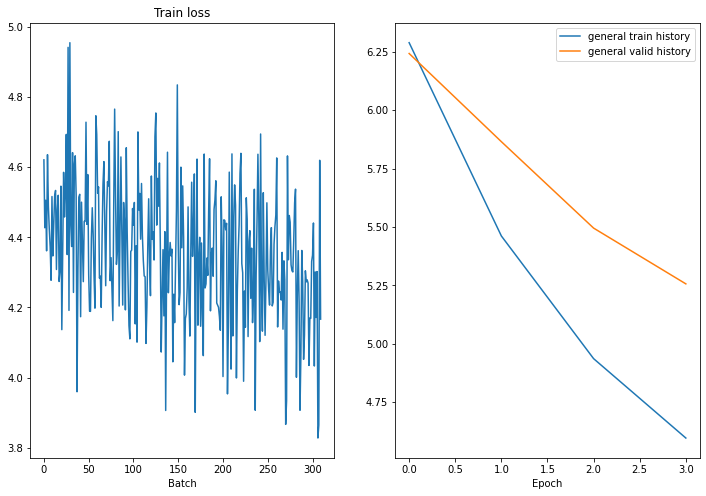

Epoch: 05 | Time: 1m 43s
	Train Loss: 4.354 | Train PPL:  77.784
	 Val. Loss: 5.087 |  Val. PPL: 161.876


In [ ]:
N_EPOCHS = 5
CLIP = 1
train_history = []
valid_history = []


best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer_bpe, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bpe_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
bpe_trg.id_to_subword(4) 

'▁'

In [ ]:
from utils import generate_translation_bpe

batch = next(iter(test_loader))
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation_bpe(src, trg, model, bpe_trg)

Original:  You can play billiards and mini-golf at the property, and the area is popular for snorkelling and windsurfing.
Generated: You can enjoy a tennis and the the the the the the the and a and the the

Original:  The Karlsruhe Exhibition Centre is a 5-minute drive from the guest house.
Generated: The Keraii Train Station is is a 10-minute drive from the property.



In [ ]:
import tqdm
from utils import remove_tech_tokens, trim
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(valid_loader)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([trim(bpe_trg.decode(x)) for x in trg.cpu().transpose(0, 1).tolist()])
        generated_text.extend([trim(bpe_trg.decode(x)) for x in output[1:].cpu().transpose(0, 1).tolist()])

59it [00:06,  8.68it/s]


In [ ]:
for i, _ in enumerate(generated_text):
  generated_text[i] = generated_text[i][0].split()
for i, _ in enumerate(original_text):
  original_text[i] = original_text[i][0].split()

In [ ]:
from utils import flatten

original_text = flatten(original_text)
generated_text = flatten(generated_text)

In [ ]:
len(generated_text)

7500

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

corpus_bleu([[text] for text in original_text], generated_text) * 100

13.615307451281469

In [ ]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

In [ ]:
#for lm-pretraining
from torch.utils import data
src_ds = CustomDataset("src.txt")
trg_ds = CustomDataset("trg.txt")

def lm_collate_fn(sentences):
    src_code = bpe_src.encode(sentences=[sentence[0] for sentence in sentences], bos=True, eos=True)
    src_code = [torch.LongTensor(x) for x in src_code]
    padded = pad_sequence(src_code)
    return Batch(padded[:-1].to(device), padded[1:].to(device))

train_lm_dl = data.DataLoader(trg_ds, batch_size=batch_size, sampler=train_sampler, collate_fn=lm_collate_fn)
valid_lm_dl = data.DataLoader(trg_ds, batch_size=batch_size, sampler=valid_sampler, collate_fn=lm_collate_fn)
test_lm_dl = data.DataLoader(trg_ds, batch_size=batch_size, sampler=test_sampler, collate_fn=lm_collate_fn)



N_EPOCHS = 5
CLIP = 1
train_history = []
valid_history = []
for name, lm in zip(['enc', 'dec'], [enc, dec]):
    optimizer_lm = torch.optim.Adam(lm.parameters())
    lm.to(device)
    best_valid_loss = float('inf')
    for epoch in range(N_EPOCHS):
        
        start_time = time.time()
        
        train_loss = train(lm, train_lm_dl, optimizer_lm, criterion, CLIP, train_history, valid_history, lm=True)
        valid_loss = evaluate(lm, valid_lm_dl, criterion, lm=True)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(lm.state_dict(), name+'lm_model.pt')
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        

TypeError: ignored

In [ ]:
model = Seq2Seq(enc, dec, device)

In [ ]:
optimizer_afterlm = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
N_EPOCHS = 5
CLIP = 1
train_history = []
valid_history = []


best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer_afterlm, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'afterlm_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
import tqdm
from utils import remove_tech_tokens, trim
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_loader)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([trim(bpe_trg.decode(x)).split() for x in trg.cpu().transpose(0, 1).tolist()])
        generated_text.extend([trim(bpe_trg.decode(x)).split() for x in output[1:].cpu().transpose(0, 1).tolist()])

from utils import flatten

original_text = flatten(original_text)
generated_text = flatten(generated_text)

from nltk.translate.bleu_score import corpus_bleu

corpus_bleu([[text] for text in original_text], generated_text) * 100

In [ ]:
#for attention
import my_network
Attention = my_network.Attention
attention = Attention(HID_DIM, HID_DIM, VOCAB_SIZE)
enc2 = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec2 = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model2 = Seq2Seq(enc2, dec2, device, attention)
optimizer2 = torch.optim.Adam(model2.parameters())

train_history = []
valid_history = []
    

In [ ]:
train_loader = torch.utils.data.DataLoader(ds, batch_size=32, 
                                           collate_fn=collate_fn, 
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(ds, batch_size=32,
                                                collate_fn=collate_fn,
                                                sampler=valid_sampler)
test_loader = data.DataLoader(ds, batch_size=32,
                             collate_fn=collate_fn, 
                             sampler=test_sampler)

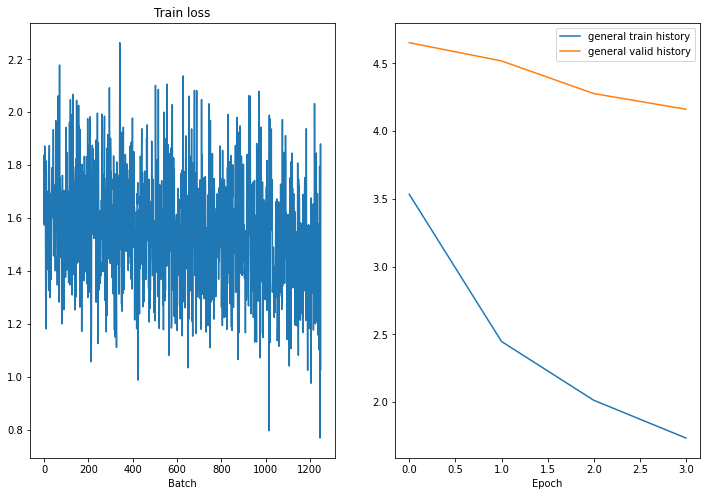

Epoch: 05 | Time: 9m 4s
	Train Loss: 1.543 | Train PPL:   4.679
	 Val. Loss: 4.112 |  Val. PPL:  61.098


In [ ]:

model2.to(device)
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model2, train_loader, optimizer2, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model2, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model2.state_dict(), 'att_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
from utils import generate_translation_bpe

batch = next(iter(test_loader))
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation_bpe(src, trg, model2, bpe_trg)

Original:  Meir Park is 400 metres from GATA, while Dizengoff Center is 700 metres away.
Generated: Me Park Park is 400 metres from G GTAA, while D Denenen Center is 700 700 metres away.

Original:  Rooms have a private bathroom. For your comfort, you will find bathrobes and a hairdryer.
Generated: Rooms have a private bathroom cloor your comfort, your comfort, and a hairdryer.



In [ ]:
import tqdm
from utils import remove_tech_tokens, trim
original_text = []
generated_text = []
model2.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_loader)):

        src = batch.src
        trg = batch.trg

        output = model2(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([trim(bpe_trg.decode(x)) for x in trg.cpu().transpose(0, 1).tolist()])
        generated_text.extend([trim(bpe_trg.decode(x)) for x in output[1:].cpu().transpose(0, 1).tolist()])

from utils import flatten

original_text = flatten(original_text)
generated_text = flatten(generated_text)

from nltk.translate.bleu_score import corpus_bleu

corpus_bleu([[text] for text in original_text], generated_text) * 100

79it [00:10,  7.69it/s]


73.7101113537702

In [ ]:
enc2 = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec2 = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)


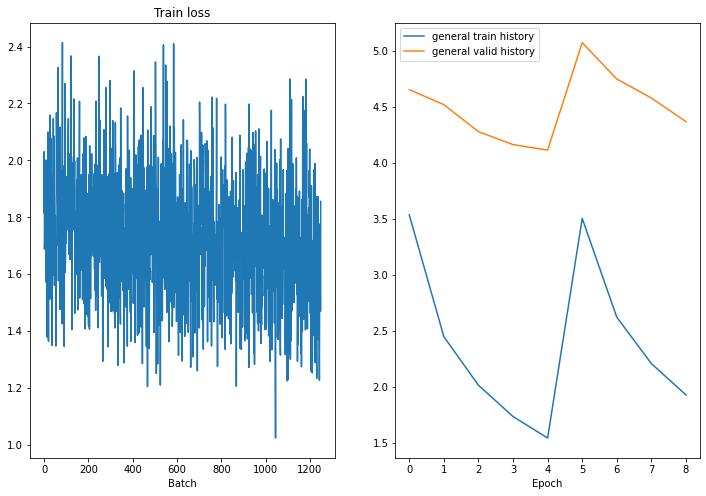

Epoch: 05 | Time: 9m 6s
	Train Loss: 1.723 | Train PPL:   5.604
	 Val. Loss: 4.325 |  Val. PPL:  75.593


In [ ]:
attention = Attention(HID_DIM, HID_DIM, VOCAB_SIZE)
enc2.load_state_dict(torch.load('enclm_model.pt'))
dec2.load_state_dict(torch.load('declm_model.pt'))
model2 = Seq2Seq(enc2, dec2, device, attention)
optimizer2 = torch.optim.Adam(model2.parameters())

train_history = []
valid_history = []

model2.to(device)
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model2, train_loader, optimizer2, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model2, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'att_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
from utils import generate_translation_bpe

batch = next(iter(test_loader))
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation_bpe(src, trg, model2, bpe_trg)

Original:  Empuriabrava is 15 minutes' drive, while Figueres is 20 km away.
Generated: Enjooo is 15 minutes’ walk away, while Foo is 20 km away.

Original:  Rooms at Al Khayam Castle are air conditioned and include minibar and a TV set.
Generated: Rooms at Alloo are air conditioned and include barbecue and a TV.



In [ ]:
import tqdm
from utils import remove_tech_tokens, trim
original_text = []
generated_text = []
model2.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_loader)):

        src = batch.src
        trg = batch.trg

        output = model2(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([trim(bpe_trg.decode(x)) for x in trg.cpu().transpose(0, 1).tolist()])
        generated_text.extend([trim(bpe_trg.decode(x)) for x in output[1:].cpu().transpose(0, 1).tolist()])

from utils import flatten

original_text = flatten(original_text)
generated_text = flatten(generated_text)

from nltk.translate.bleu_score import corpus_bleu

corpus_bleu([[text] for text in original_text], generated_text) * 100

79it [00:10,  7.53it/s]


68.60039881869547

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

corpus_bleu([[text] for text in original_text], generated_text) * 100